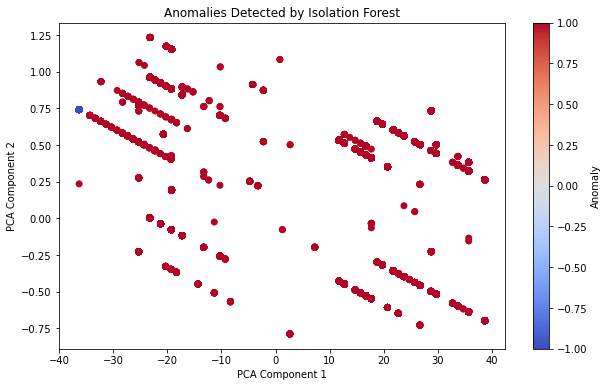

Total Anomalies Found: 342


,Trace-id,Total Requests,Count_200,Count_404,Count_5xx,Unique Paths,Avg Path Depth,Avg Path Length,Unique User Agents,Prop_200,Prop_404,Prop_5xx,Anomaly
594,00d287a81f172afbe83fdb3f31dccf29,1,0,1,0,1,1.0,1.0,1,0.0,1.0,0.0,-1
941,014df6ff0b3265d0b2d0fe740356fb54,1,0,1,0,1,1.0,1.0,1,0.0,1.0,0.0,-1
3074,042f45b7d7568ab4b253363db00bd638,1,0,1,0,1,1.0,1.0,1,0.0,1.0,0.0,-1
3401,049af607ecc8ec38fa857aa2cd3c4ad3,1,0,1,0,1,1.0,1.0,1,0.0,1.0,0.0,-1
3766,0516871d574697247cb95f6903dbe6a5,1,0,1,0,1,1.0,1.0,1,0.0,1.0,0.0,-1


In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the dataset
file_path = '/Users/vatsal/Desktop/consolidated_trace_data_final2.csv'
data = pd.read_csv(file_path)

# Fill missing values
data['HTTP Status Code'].fillna(-1, inplace=True)  # Use -1 for missing status codes
data['User Agent'].fillna('Unknown', inplace=True)

# Feature extraction
# 1. Aggregate features per Trace-id
trace_features = data.groupby('Trace-id').agg({
    'HTTP Status Code': ['count', lambda x: (x == 200).sum(), lambda x: (x == 404).sum(), lambda x: (x >= 500).sum()],
    'Path': ['nunique', lambda x: np.mean(x.str.count('/')), lambda x: np.mean(x.str.len())],
    'User Agent': 'nunique'
}).reset_index()

trace_features.columns = [
    'Trace-id', 'Total Requests', 'Count_200', 'Count_404', 'Count_5xx',
    'Unique Paths', 'Avg Path Depth', 'Avg Path Length', 'Unique User Agents'
]

# 2. Proportion of status codes
trace_features['Prop_200'] = trace_features['Count_200'] / trace_features['Total Requests']
trace_features['Prop_404'] = trace_features['Count_404'] / trace_features['Total Requests']
trace_features['Prop_5xx'] = trace_features['Count_5xx'] / trace_features['Total Requests']

# Normalizing and preparing data for modeling
feature_cols = ['Total Requests', 'Unique Paths', 'Avg Path Depth', 'Avg Path Length',
                'Unique User Agents', 'Prop_200', 'Prop_404', 'Prop_5xx']
X = trace_features[feature_cols]

# Handle missing or infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Isolation Forest for anomaly detection
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
trace_features['Anomaly'] = model.fit_predict(X)

# Visualize anomalies
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=trace_features['Anomaly'], cmap='coolwarm')
plt.title('Anomalies Detected by Isolation Forest')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Anomaly')
plt.show()

# Analyzing anomalies
anomalies = trace_features[trace_features['Anomaly'] == -1]
print(f"Total Anomalies Found: {len(anomalies)}")
anomalies.head()